<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords as nltk_stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

## Загрузка данных

In [4]:
data = pd.read_csv('datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка данных

In [5]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
data.duplicated().sum()

0

In [7]:
data.dtypes

text     object
toxic     int64
dtype: object

In [8]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [9]:
data.shape

(159292, 2)

In [10]:
data['toxic'].unique()

array([0, 1])

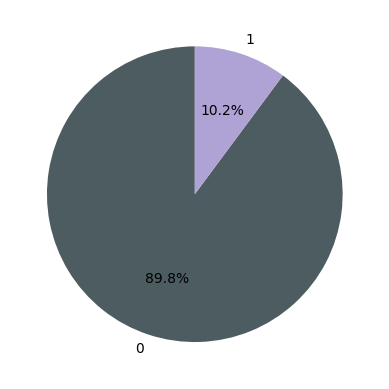

In [11]:
toxic_counts = data['toxic'].value_counts()

plt.pie(toxic_counts, labels=toxic_counts.index.astype(str), autopct='%1.1f%%', startangle=90, colors=['#4D5C60', '#AFA3D5'])
plt.show()

В столбце toxic наблюдается дисбаланс классов

### Очистка текста

In [12]:
data['text'] = data['text'].str.lower()

In [13]:
data['text'] = data['text'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
data['text'] = data['text'].apply(lambda text: text.replace('\n', ' '))

### Удаление стоп-слов

In [14]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
data['text'] = data['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


### Лемматизация

In [15]:
tqdm.pandas()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_sentence_spacy(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

data['text'] = data['text'].progress_apply(lemmatize_sentence_spacy)

100%|██████████| 159292/159292 [08:05<00:00, 328.25it/s]


### TF-IDF

In [18]:
X = data.drop("toxic", axis=1)
y = data['toxic']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [20]:
corpus_train = X_train['text']
corpus_test = X_test['text']

tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(corpus_train)
X_test = tf_idf.transform(corpus_test)

## Обучение моделей

### LogisticRegression

In [22]:
param_grid = {
    'C': [1, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] 
}

log_model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, 
                           scoring='f1', cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший средний балл: {grid_search.best_score_}')


Лучшие параметры: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший средний балл: 0.7632340760585224


In [23]:
log_model = grid_search.best_estimator_

### CatBoost

In [24]:
param_grid = {
    'depth': [4, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [200]
}

cat_model = CatBoostClassifier(verbose=0) 

grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший результат: {grid_search.best_score_}')

Лучшие параметры: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Лучший результат: 0.7102875572300612


In [25]:
cat_model = grid_search.best_estimator_

## Тестирование

Для предсказания на тестовой выборке возьмем модель LogisticRegression

In [26]:
y_pred = log_model.predict(X_test)
log_f1 = f1_score(y_test, y_pred)
print(f'Метрика F1 = {round(log_f1, 2)}')

Метрика F1 = 0.77


## Вывод

В ходе проекта была выполнена задача по классификации токсичных комментариев для интернет-магазина «Викишоп». Основные шаги:

**Предобработка данных:**
* Тексты комментариев очищены;
* Произведена лемматизация для приведения слов к начальной форме;
* Применён метод TF-IDF для векторизации текстов.

**Моделирование:**
* Были протестированы различные модели, среди которых наилучший результат показала **LogisticRegression**;
* После подбора гиперпараметров и обучения модели удалось достичь значения **F1-метрики = 0.77**, что выше целевого значения (0.75).

Данный результат подтверждает, что модель эффективно справляется с задачей классификации токсичных комментариев.
